In [46]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from utils import double_division_tracks, curated_tracks, DATA_ROOT

import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline
import matplotlib.cm as cm
from matplotlib import pyplot as plt
plt.style.use('_classic_test')
import seaborn as sns

from notebook_functions import timelapse_double_frame_sync, umap_transform, circular_tracking

log_const = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
size = 20
df = pd.read_csv(DATA_ROOT / 'Spots in tracks statistics.csv', na_values="None", delimiter='\t', header=0,
                 usecols=['ID', 'TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']).dropna().astype(int)
df = df.loc[df['FRAME'] >= 10]
frames = sorted(df['FRAME'].unique())

In [33]:
def get_frame_average(img, coords, sz, fun=np.median):
    """Calculate `fun` across selected patches"""

    sz2 = sz // 2
    mask = np.zeros_like(img, dtype=bool)
    for y, x in coords:
        left, top = max(0, x - sz2), max(0, y - sz2)
        mask[top: y + sz2, left: x + sz2] = True
    return fun(img[mask])

def get_channel_intensities(coords, frame_num, channel_root, sz=20):
    """Get cell intensities for a channel"""

    sz2 = sz // 2
    frame_name = f'T{frame_num + 1:0>3}'
    img = cv2.imread(str(channel_root / frame_name), cv2.CV_16U)
    frame_average = get_frame_average(img, coords, sz)

    intensities = []
    for y, x in coords:
        left, top = max(0, x - sz2), max(0, y - sz2)
        intensity = np.median(img[top: y + sz2, left: x + sz2]) - frame_average
        intensities.append(intensity)
    return np.array(intensities)

def process_frame(df, frame_num, size):
    coords = df.loc[df['FRAME'] == frame_num, ['POSITION_Y', 'POSITION_X']].values
    intensities = []
    for channel in ['GFP', 'Cy3']:
        channel_root = DATA_ROOT / channel
        intensities.append(get_channel_intensities(coords, frame_num, channel_root, sz=size))
    return np.column_stack(intensities)

In [34]:
frame_num = 11
intensities = process_frame(df, frame_num, size)

## U-Map embedding

In [2]:
df = pd.read_csv(DATA_ROOT / 'intensities_pred.csv')
intensities = df[['GFP_pred', 'Cy3_pred']].values

In [3]:
intensities = intensities[::10]

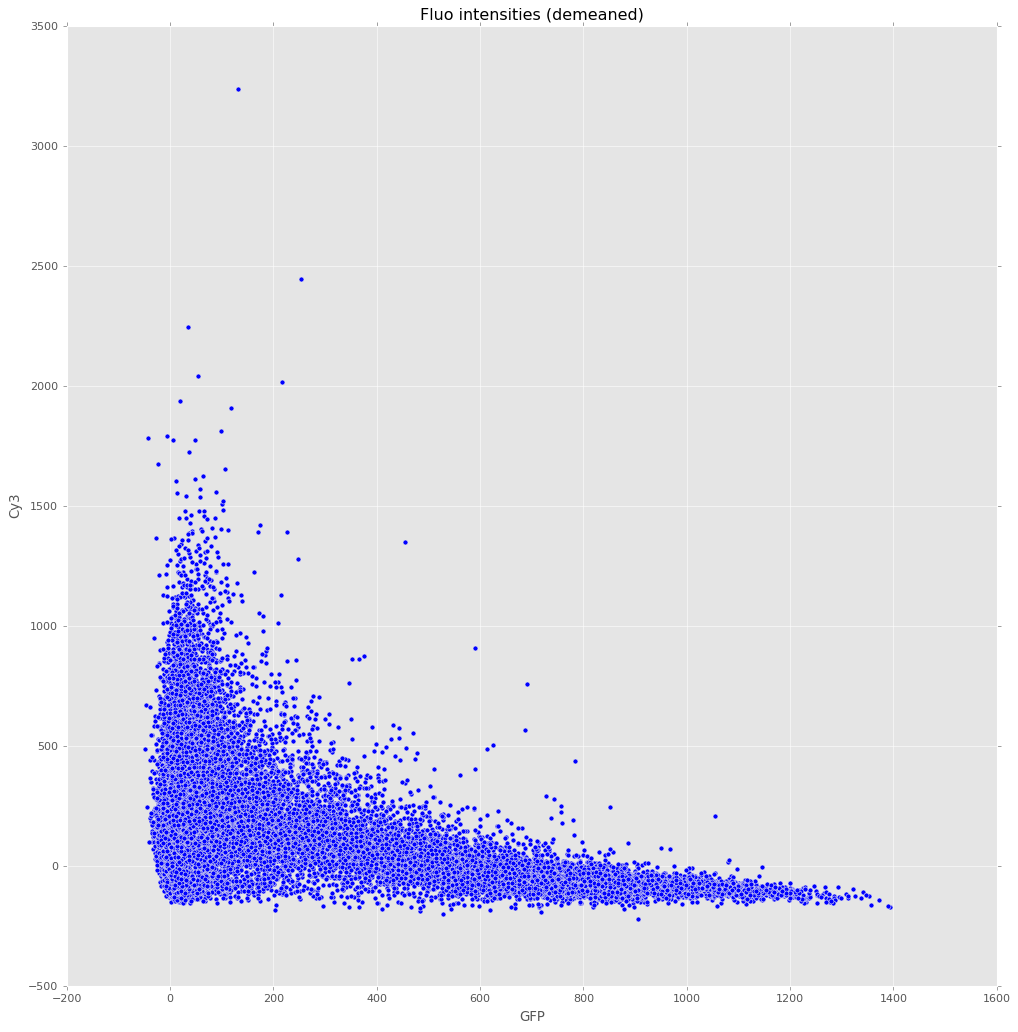

In [76]:
fig = plt.figure(figsize=(15, 15))
plt.scatter(intensities[:, 0], intensities[:, 1])
plt.ylabel('Cy3')
plt.xlabel('GFP')
_ = plt.title('Fluo intensities (demeaned)')

In [ ]:
metric = 'correlation'
embeddings, umap_model = umap_transform(intensities, n_neighbors=200, min_dist=0.95, n_components=2, metric=metric)

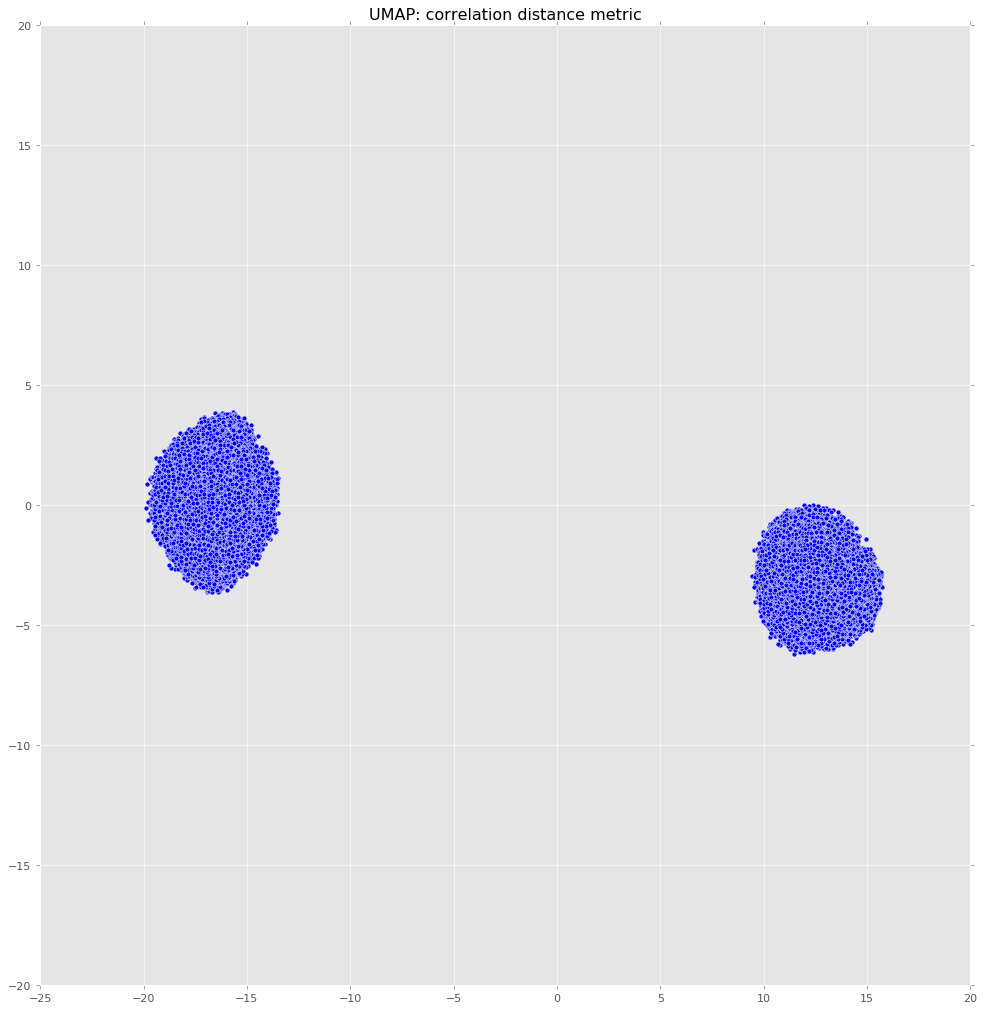

In [71]:
fig = plt.figure(figsize=(15, 15))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.ylim(-20, 20)
_ = plt.title('UMAP: correlation distance metric')

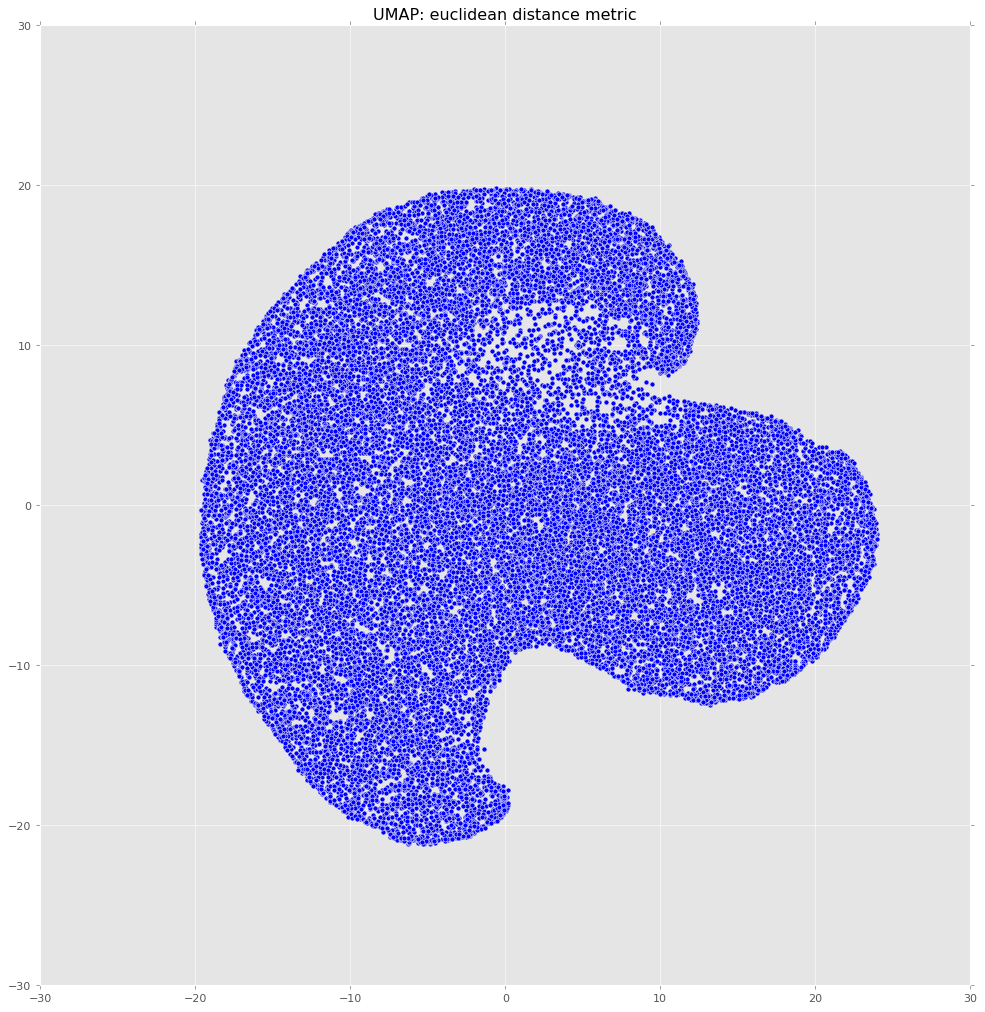

In [64]:
metric = 'euclidean'
embeddings_eucl, umap_model_eucl = umap_transform(np.log(intensities + log_const), n_neighbors=200, min_dist=0.95, n_components=2, metric=metric)

fig = plt.figure(figsize=(15, 15))
plt.scatter(embeddings_eucl[:, 0], embeddings_eucl[:, 1])
_ = plt.title('UMAP: euclidean distance metric')

## Finding average track with SOM clustering

In [67]:
import sompy
mapsize = 50
som = sompy.SOMFactory.build(embeddings, mapsize, mask=None, mapshape='planar', lattice='rect',
                             normalization='None', initialization='pca', neighborhood='gaussian',
                             training='batch', name='sompy', track_history=True)
som.train(n_job=1, verbose=None)

som_matrix = som.codebook.matrix
som_bmu = som._bmu[0].astype(int)

input was considered as the numbers of nodes
map size is [1,50]


In [68]:
fun = np.median
som_track = []
for cluster in np.sort(np.unique(som_bmu)):
    som_track.append(fun(intensities[som_bmu == cluster], 0))
som_track = np.array(som_track)

Text(0.5, 1.0, 'Embedded intensities, SOM average')

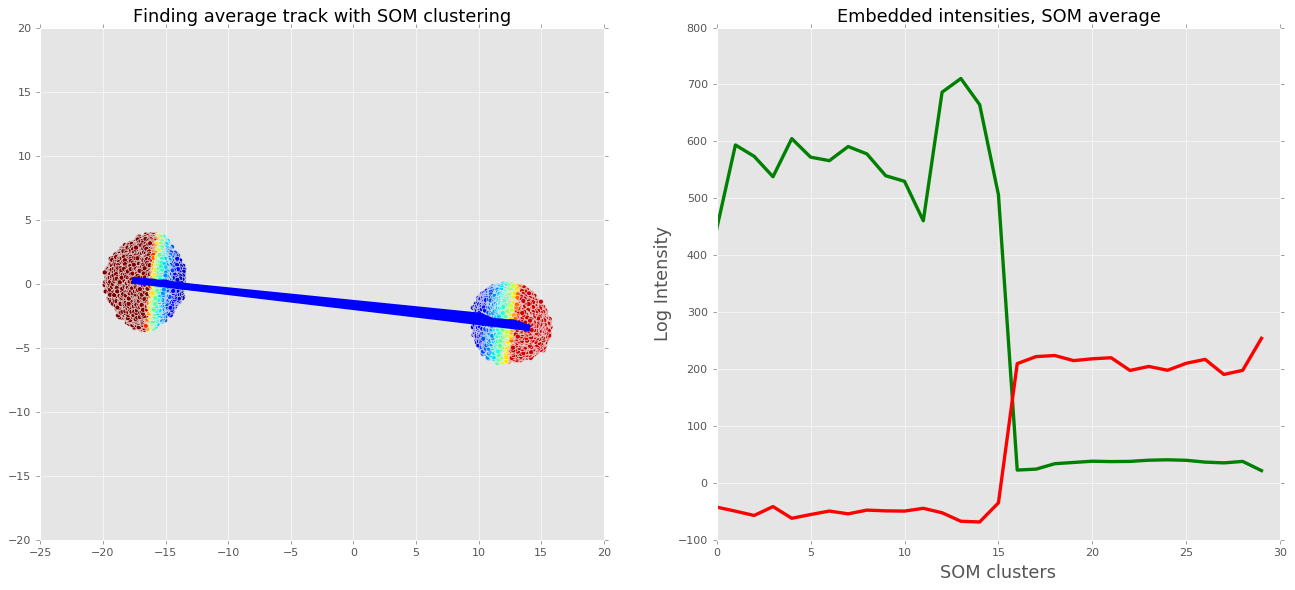

In [70]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 8))

color = 'blue'
ax = fig.add_subplot(121)
ax.scatter(embeddings[:,0], embeddings[:,1], c=np.abs(som_bmu - mapsize / 2))
ax.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax.set_title('Finding average track with SOM clustering', fontsize=16)
ax.set_ylim(-20, 20)

ax = fig.add_subplot(122)
ax.plot(som_track[:, 0], c='green', linewidth=3)
ax.plot(som_track[:, 1], c='red', linewidth=3)
ax.set_ylabel('Log Intensity', fontsize=16)
ax.set_xlabel('SOM clusters', fontsize=16)
ax.set_title('Embedded intensities, SOM average', fontsize=16)